# And then there was data

Right, now we have an incling of the method we might use to get arms from a galaxy, let's see how it fares against actual data (from the beta of galaxy-builder)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from ipywidgets import FloatProgress
from IPython.display import display
import json
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)
    
np.random.seed(299792458)

In [2]:
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, foo = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))
subjectId = subjects[index]['id']
print(subjectId)

14813274


In [3]:
cls = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in cls]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [
        [[p['x'], p['y']] for p in a] 
        for a in c
    ]
    for c in spirals if all([len(a) > 5 for a in c])
]

To ensure we've grabbed things correctly, let's plot all our drawn arms!

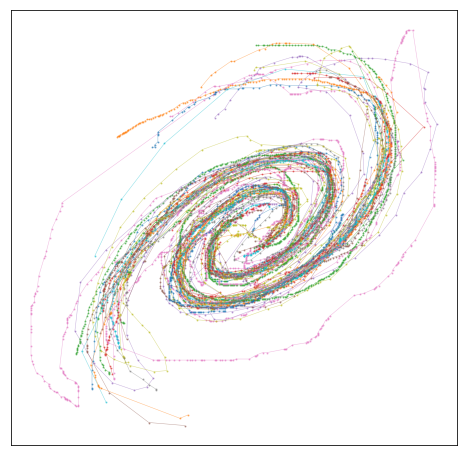

In [4]:
plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
for index, arms in enumerate(spiralsWithLengthCut):
    for arm in arms:
        plt.plot([i[0] for i in arm], [i[1] for i in arm], '.', markersize=2, alpha=0.5, c='C{}'.format(index % 10))
        plt.plot([i[0] for i in arm], [i[1] for i in arm], '', linewidth=0.5, alpha=0.5, c='C{}'.format(index % 10))

It looks good! ALbeit very messy... Now to run the extraction on it

First step is to move the array of classifications into an array of drawn arms (ignoring the potentially useful information that each volunteer will only have drawn each arm once...)

In [5]:
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

## Import the algorithm

Because I don't know how to best use jupyter, redo some of the cells from the previous chapter:

In [6]:
# calculate dot(a) of a(n,2), b(n,2): np.add.reduce(b1 * b2, axis=1)
# calucalte norm(a) of a(n,2), b(n,2): np.add.reduce((a-b)**2, axis=1)
def calcT(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    dots = np.add.reduce(b1 * b2, axis=1)
    l2 = np.add.reduce((a[:, 1] - a[:, 2])**2, axis=1)
    out = np.clip(dots / l2, 0, 1)
    return out

def getDiff(t, a):
    projection = a[:,1,:] + np.repeat(t.reshape(-1, 1), 2, axis=1) * (a[:,2,:] - a[:,1,:])
    out = np.add.reduce((a[:,0,:]-projection) * (a[:,0,:]-projection), axis=1)
    return np.sqrt(np.min(out))

vCalcT = np.vectorize(calcT, signature='(a,b,c)->(a)')
vGetDiff = np.vectorize(getDiff, signature='(a),(a,b,c)->()')

def minimum_distance(a, b):
    d = 0
#     print(np.roll(b, 1, axis=0))
    m = np.zeros((a.shape[0], b.shape[0]-1, 3, 2))
    m[:, :, 0, :] = np.transpose(np.tile(a, [m.shape[1]+1, 1, 1]), axes=[1, 0, 2])[:, :-1, :]
    m[:, :, 1, :] = np.tile(b, [a.shape[0], 1, 1])[:, :-1, :]
    m[:, :, 2, :] = np.tile(np.roll(b, -1, axis=0), [a.shape[0], 1, 1])[:, :-1, :]
    t = vCalcT(np.array(m))
    return np.sum(vGetDiff(t, m))/a.shape[0]
    
def arcDistanceFast(a, b):
    return (
        minimum_distance(a, b) +
        minimum_distance(b, a)
    )

## Identifying arms

First, create the distances array as before:

64.17953085899353


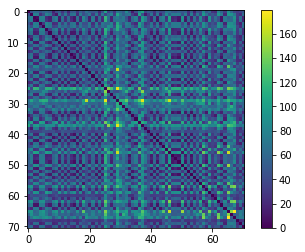

In [7]:
import time
def calculateDistanceMatrix(cls):
    n = len(cls)**2/2 - len(cls)/2
    f = FloatProgress(min=0, max=n)
    display(f)
    distances = np.zeros((len(cls), len(cls)))
    t0 = time.time()
    for i in range(len(cls)):
        for j in range(i+1, len(cls)):
            f.value += 1
            distances[i,j] = arcDistanceFast(cls[i], cls[j])
    distances += np.transpose(distances)
    return distances

t0 = time.time()

distances = calculateDistanceMatrix(drawnArms)

print(time.time() - t0)

plt.imshow(distances)
plt.colorbar()

Now make use of DBSCAN to group arms, defining the max distance between two arms in a core group to be 20, partially guided by our plot above.

In [8]:
# initialise fitter and fit! 
db = DBSCAN(eps=20, min_samples=3, metric='precomputed', n_jobs=-1, algorithm='brute')
db.fit(distances)

# Obtain clustering results
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
armLabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(armLabels)) - (1 if -1 in armLabels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


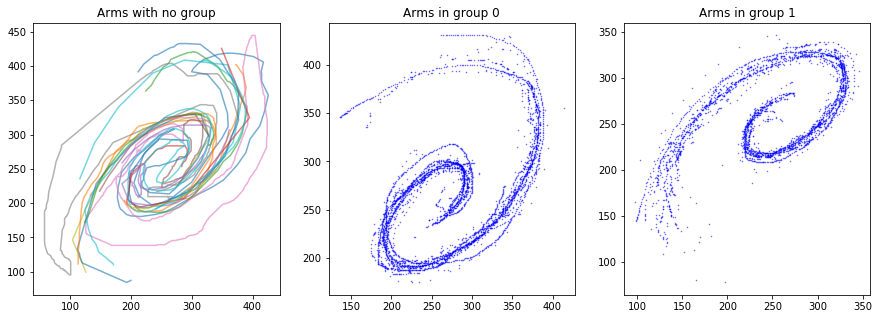

In [9]:
fig, ax = plt.subplots(ncols=len(np.unique(armLabels)), figsize=(15, 5))
for i, label in enumerate(np.unique(armLabels)):
    if label == -1:
        ax[i].set_title('Arms with no group')
    else:
        ax[i].set_title('Arms in group {}'.format(label))
    identified = drawnArms[np.where(armLabels == label)]
    for arm in identified:
        ax[i].plot(arm[:, 0], arm[:, 1], ('b.' if i > 0 else ''), markersize=1, alpha=0.6)


Well we have arms!!

The next step is to order the points in such a way we can fit a curved spline to them. We pick the arm with $\mathrm{label}=0$ to demonstrate

In [10]:
label = 0
pointCloud = np.array([
    point for arm in drawnArms[armLabels == label] 
    for point in arm
])

In [11]:
print('Total number of points:', np.array([point for arm in drawnArms for point in arm]).shape[0])
print('Arm 0 number of points:', pointCloud.shape)

Total number of points: 8101
Arm 0 number of points: (3743, 2)


In [12]:
from scipy.interpolate import UnivariateSpline

def rThetaFromXY(x, y, mux=0, muy=0):
    return np.sqrt((x - mux)**2 + (y - muy)**2), np.arctan2((y - muy),(x - mux))

def xyFromRTheta(r, theta, mux=0, muy=0):
    return mux + r*np.cos(theta), muy + r*np.sin(theta)

## Cleaning up the data

Let's make use of some outlier detection to clean up the data as best as possible. 

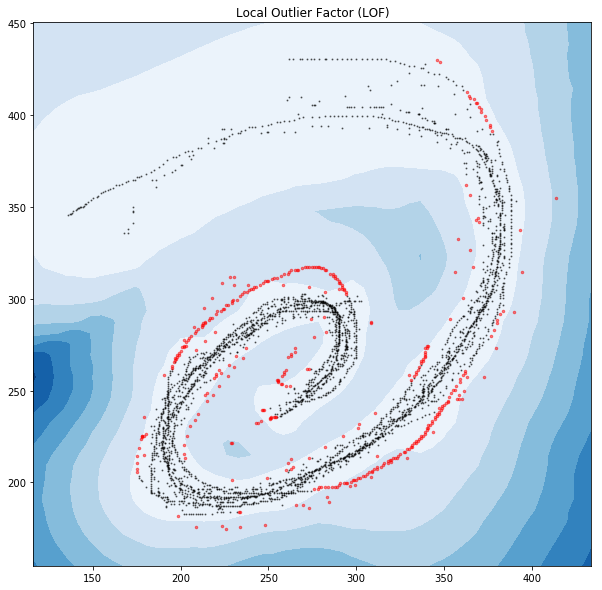

In [13]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=50)
y_pred = clf.fit_predict(pointCloud)
mask = ((y_pred + 1) / 2).astype(bool)
y_pred_outliers = y_pred[200:]
xx, yy = np.meshgrid(
    np.linspace(np.min(pointCloud[:, 0]) - 20, np.max(pointCloud[:, 0]) + 20, 50), 
    np.linspace(np.min(pointCloud[:, 1]) - 20, np.max(pointCloud[:, 1]) + 20, 50)
)
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

cleanedCloud = pointCloud[mask]

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.set_title("Local Outlier Factor (LOF)")
ax.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], 'k.', markersize=2, alpha=0.5)
ax.plot(pointCloud[np.logical_not(mask), 0], pointCloud[np.logical_not(mask), 1], 'r.', markersize=5, alpha=0.5)

# Ordering points

In order to fit a smoothed spline to the data points, we must first unwrap the spiral somehow, in a way which makes as few assumptions as possible. The method used in chapter one clumps data points and then orders inside this clump by theta from a central point, but still assumes almost circular symmetry, which will not be the general case. Other options are therefore explored.

## Attempt 1: Grouping nearby points into uniform clusters using unsupervised machine learning (as in chapter one)

Catchy title, huh? Spectral clustering was suuuper slow, so we'll use agglomerative instead.

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

knn_graph = kneighbors_graph(cleanedCloud, 30, include_self=False)
model = AgglomerativeClustering(linkage='ward', connectivity=knn_graph, n_clusters=15)
model.fit(cleanedCloud)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<3368x3368 sparse matrix of type '<class 'numpy.float64'>'
	with 101040 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=15,
            pooling_func=<function mean at 0x107991268>)

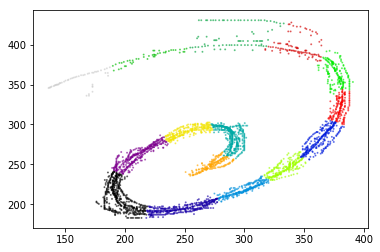

In [15]:
plt.scatter(cleanedCloud[:, 0], cleanedCloud[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral, s=1, alpha=0.5)

Okay, we have our clumps, now we translate to be roughly centered at 0, 0 and then sort each by theta, making sure to properly account for cases where theta could run from positive through to negative

In [16]:
sortedBatches = []
means = np.zeros((len(np.unique(model.labels_)), 2))
count = 0
pc2 = cleanedCloud - [250, 250]
for i, sublabel in enumerate(np.unique(model.labels_)):
    mask = model.labels_ == sublabel
    r, theta = rThetaFromXY(pc2[mask, 0], pc2[mask, 1])
    if min(theta) < -3*np.pi/4 and 3* max(theta) > np.pi/4:
        theta[theta < -np.pi / 2] += 2*np.pi
    args = np.argsort(theta)
    sortedBatches.append(cleanedCloud[mask][args])
    count += r.shape[0]
    means[i] = [np.mean(pc2[mask, 0]), np.mean(pc2[mask, 1])]

In [17]:
means

array([[-5.35775424e+01, -4.04669492e+01],
       [-3.94851312e+01,  1.08673469e+01],
       [-2.31825613e+00, -5.47253406e+01],
       [ 1.13690441e+02,  3.13419118e+01],
       [ 4.95411523e+01, -3.12098765e+01],
       [ 3.91150754e+01,  3.42113065e+01],
       [ 4.30500000e+01,  1.61163953e+02],
       [-3.00804348e+01,  1.34384783e+02],
       [ 1.26884746e+02,  1.13671186e+02],
       [ 8.41486607e+01, -4.49821429e+00],
       [ 2.91791667e+00,  4.10983333e+01],
       [ 2.37060109e+01, -4.15300546e-02],
       [ 1.30142775e+02,  7.12040462e+01],
       [ 9.48382979e+01,  1.46990426e+02],
       [-8.95680000e+01,  1.05274000e+02]])

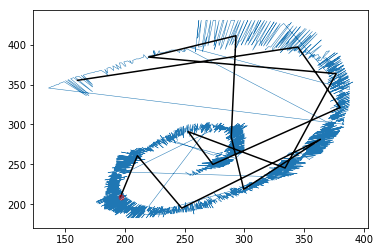

In [18]:
r, theta = rThetaFromXY(means[:, 0], means[:, 1])
a = np.argsort(r)
result = np.array([p for i in a for p in sortedBatches[i]])
plt.plot(result[:, 0], result[:, 1], linewidth=0.5)
plt.plot(means[:, 0]+250, means[:, 1]+250, 'k')
plt.plot(means[0, 0]+250, means[0, 1]+250, 'r.', markersize=10, alpha=0.4)

In [19]:
from sklearn.neighbors import BallTree
tree = BallTree(means)

In [20]:
dist, ind = tree.query([means[0]], k=5)
len(means), dist, ind

(15,
 array([[ 0.        , 53.20541469, 53.23350456, 87.21790023, 99.22011993]]),
 array([[ 0,  2,  1, 11, 10]]))

## Attempt 2: Principal component analysis

If we take a subsample of the data points, and at each point identify the principal component, we should end up with an overall "flow" of the data at that point. This (somehow) could be used to order / fit data to those points?

In [21]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mask = np.ones(cleanedCloud.shape[0], dtype=bool) #np.random.randn(cleanedCloud.shape[0])>0
keyPoints = cleanedCloud[mask]

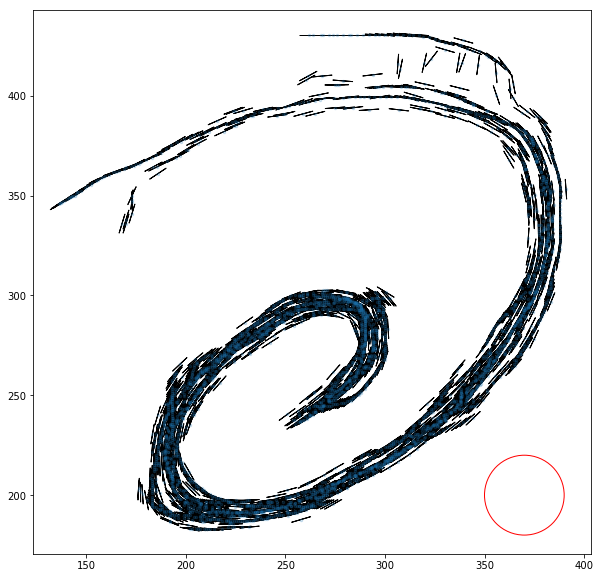

In [22]:
from matplotlib.patches import Ellipse
patchSize = 20
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=5, alpha=0.2)
vectors = np.zeros((keyPoints.shape[0], 2))
for i, point in enumerate(keyPoints):
    ax.plot(point[0], point[1], 'r', markersize=10, alpha=0.2)
    radialMask = np.add.reduce((cleanedCloud - point)**2, axis=1) < patchSize**2
    pcaResult = pca.fit(cleanedCloud[radialMask])
    vectors[i] = pcaResult.components_[0]
    ax.arrow(
        point[0]-5*vectors[i][0], point[1]-5*vectors[i][1],
        10*vectors[i][0], 10*vectors[i][1],
        width=0.0001, head_width=0, head_length=0,
        fc='k', ec='k'
    )
ax.add_artist(Ellipse(
    xy=[370,200],
    width=patchSize*2,
    height=patchSize*2,
    facecolor='none',
    edgecolor='r'
))

## Go with the flow

Okay, we now have a kind of "river", what would happen if we drop a couple of sticks in the stream? What would their path be?

Provided a start point, we'll take a circular average of the flow lines (aligned with the current "flow")

In [23]:
def circularMean(theta):
    return np.angle(np.sum(np.exp(theta*1j)))

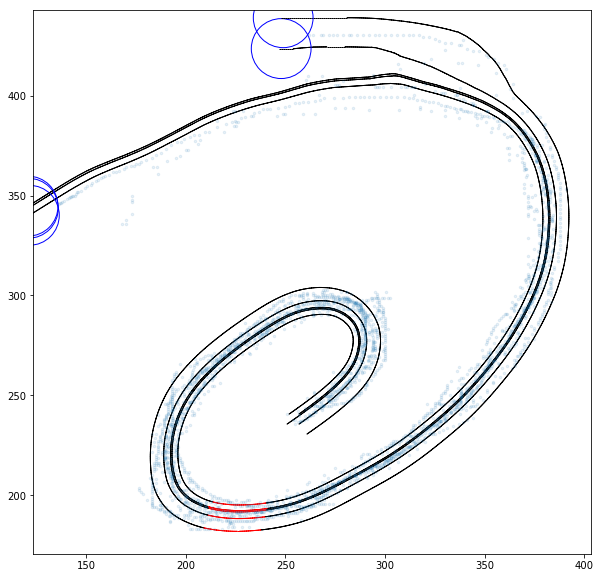

In [24]:
stepSize = 1
patchRadius = 15

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=5, alpha=0.1)

initialPoints = [
    np.array([256.0, 240.0]),
    np.array([256.0, 235.0]),
    np.array([251.0, 240.0]),
    np.array([250.0, 235.0]),
    np.array([260.0, 230.0]),
]
for startPoint in initialPoints:
    pos = startPoint.copy() # np.array([250.0, 195.0]) # cleanedCloud[2300].copy()
    deltaPos = np.array([1, 0])
    while True:
        radialMask = np.add.reduce((keyPoints - pos)**2, axis=1) < patchRadius**2
        if(np.any(radialMask)):
            vectorDirectionWrtFlow = np.sign(np.add.reduce(vectors[radialMask]*deltaPos, axis=1))
            shouldRotateVector = vectorDirectionWrtFlow < 0

            rs, thetas = rThetaFromXY(vectors[radialMask, 0], vectors[radialMask, 1])

            alignedThetas = (thetas + shouldRotateVector * np.pi) % (2*np.pi)

            stdev = np.std(alignedThetas.astype(np.float64))
            fc = 'k' if stdev < 1 and len(np.where(radialMask)[0] > 5) else 'r'

            theta = circularMean(alignedThetas)
            deltaPos = xyFromRTheta(stepSize, theta)
            pos += deltaPos
            ax.arrow(
                pos[0], pos[1],
                deltaPos[0], deltaPos[1],
                width=0.0001, head_width=0, head_length=0,
                fc=fc, ec=fc
            )
        else:
            break
    ax.add_artist(Ellipse(
        xy=pos,
        width=patchRadius*2,
        height=patchRadius*2,
        facecolor='none',
        edgecolor='b'
    ))


Well that's... interesting.

Three of the five starting points continued all the way round to the end of the spiral and two followed another line off to the side (without really complaining about being unsure of where  they were supposed to be going). 

In testing, certain patch radii will cause paths to decide to double back on themselves (following a batch of being very confused - signified by the red parts of the line).

Potentially promising, but the method is definitely being confused by the one strong line drawn off to the top of the image.

### Identifying starting points

We now need to figure out where best to drop our stick. We'll cluster the start and end points of every drawn arm (when that point hasn't been filtered out as an outlier?). Then we grab the cluster with mean nearest the centre of the image and see if there is an obvious preferential "finish" point downstream!

In [25]:
coordInCloud = lambda coord: np.any(
    np.logical_and(
        cleanedCloud[:, 0] == coord[0],
        cleanedCloud[:, 1] == coord[1]
    )
)

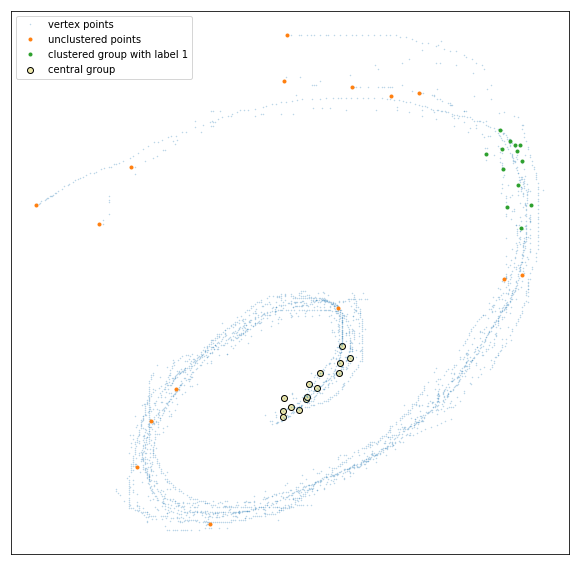

In [26]:
startPoints = np.array([i[0] for i in drawnArms[armLabels == label] if coordInCloud(i[0])])
endPoints = np.array([i[-1] for i in drawnArms[armLabels == label] if coordInCloud(i[-1])])
startEndPoints = np.concatenate((startPoints, endPoints))

db_startEndPoints = DBSCAN(eps=15, min_samples=3, n_jobs=-1)
db_startEndPoints.fit(startEndPoints)

plt.figure(figsize=(10, 10))
plt.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', label='vertex points', markersize=1, alpha=0.3)

means = np.array([
    np.add.reduce(startEndPoints[db_startEndPoints.labels_ == l])/startEndPoints[db_startEndPoints.labels_ == l].shape[0]
    for l in range(np.max(db_startEndPoints.labels_))
])

startEndMask = np.zeros(startEndPoints.shape[0], dtype=bool)
startEndMask[:startPoints.shape[0]] = True
centralGroupLabel = np.argmin(np.add.reduce((means - [256, 256])**2, axis=1))
for l in np.unique(db_startEndPoints.labels_):  
    thisGroup = startEndPoints[db_startEndPoints.labels_ == l]
    if l == centralGroupLabel:
        plt.scatter(thisGroup[:, 0], thisGroup[:, 1], c='palegoldenrod', edgeColor='k', label="central group")
    else:
        plt.plot(
            thisGroup[:, 0], thisGroup[:, 1],
            '.', label=('unclustered points' if l < 0 else 'clustered group with label {}'.format(l))
        )
plt.xticks([])
plt.yticks([])
plt.legend()

A by-product of this step is identifying a potential cluster of "end" points (shown in green in the above plot). Later on we can concatenate the spiral at this point if needed.

Start a stick in the stream for each of our identified "origin" points!

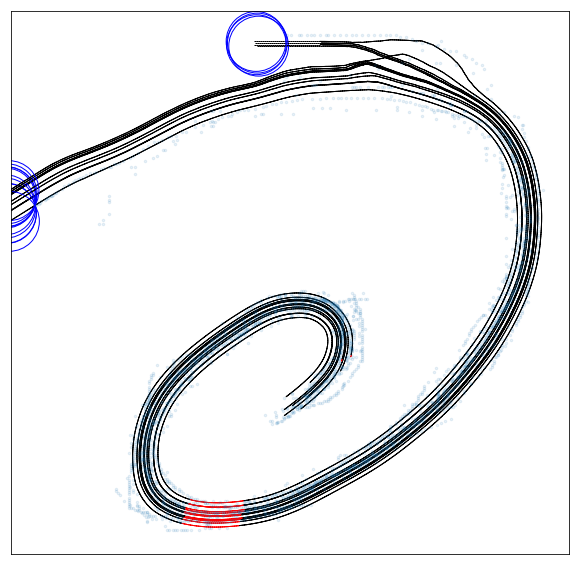

In [27]:
stepSize = 1
patchRadius = 15

downStreamPoints = []
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
plt.xticks([])
plt.yticks([])

ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=5, alpha=0.1)

for startPoint in startEndPoints[db_startEndPoints.labels_ == centralGroupLabel]:
    pos = startPoint.copy() # np.array([250.0, 195.0]) # cleanedCloud[2300].copy()
    deltaPos = np.array([1, 0]) # TODO: this should not be such a strong prior
    while True:
        radialMask = np.add.reduce((keyPoints - pos)**2, axis=1) < patchRadius**2
        if(np.any(radialMask)):
            vectorDirectionWrtFlow = np.sign(np.add.reduce(vectors[radialMask]*deltaPos, axis=1))
            rs, thetas = rThetaFromXY(vectors[radialMask, 0], vectors[radialMask, 1])
            shouldRotateVector = vectorDirectionWrtFlow < 0
            alignedThetas = (thetas + shouldRotateVector * np.pi) % (2*np.pi)
            stdev = np.std(alignedThetas.astype(np.float64))
            fc = 'k' if stdev < 1 and len(np.where(radialMask)[0] > 5) else 'r'
            theta = circularMean(alignedThetas)
            deltaPos = xyFromRTheta(stepSize, theta)
            pos += deltaPos
            ax.arrow(
                pos[0], pos[1],
                deltaPos[0], deltaPos[1],
                width=0.0001, head_width=0, head_length=0,
                fc=fc, ec=fc
            )
        else:
            break
    downStreamPoints.append(pos.copy())
    ax.add_artist(Ellipse(
        xy=pos,
        width=patchRadius*2,
        height=patchRadius*2,
        facecolor='none',
        edgecolor='b'
    ))
downStreamPoints = np.array(downStreamPoints)

We can definitely see two nuclei emerging, what is interesting is that the previous plot containing drawn arm start and end points show that most drawn arms don't extend as far as our stream does. However, as we want to parametrise all points, this is desirable.

Choose the start point of our final "flow line" to be the mean of all points which resulted in the largest downstream cluster:

In [28]:
db_downStreamPoints = DBSCAN(eps=15, min_samples=3, n_jobs=-1)
db_downStreamPoints.fit(downStreamPoints)
clusterSizes = [
    sum(1 for i in db_downStreamPoints.labels_ == clusterLabel if i) 
    for clusterLabel in range(max(db_downStreamPoints.labels_ + 1))
]
mask = db_downStreamPoints.labels_ == np.argmax(clusterSizes)
np.random.seed(299792458)
pointsInMainCluster = startEndPoints[db_startEndPoints.labels_ == centralGroupLabel][mask]
chosenStartPoint = np.add.reduce(pointsInMainCluster) / pointsInMainCluster.shape[0]
print('Chosen start point:', chosenStartPoint)

Chosen start point: [270.64 250.64]


And now we drop a stick there, save the path and then reverse the flow direction to explore the "upstream" part of the spiral (as otherwise there would be a large number of missed points)

([], <a list of 0 Text yticklabel objects>)

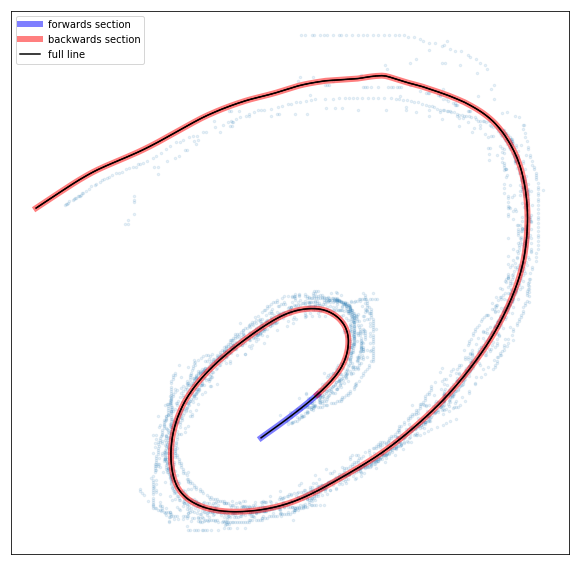

In [29]:
stepSize = 1
patchRadius = 15

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=5, alpha=0.1)

pos = chosenStartPoint.copy() # np.array([250.0, 195.0]) # cleanedCloud[2300].copy()
deltaPos = np.array([1, 0]) # TODO: this should not be such a strong prior

spiralPolygonForwards = [pos.copy()]

while True:
    radialMask = np.add.reduce((keyPoints - pos)**2, axis=1) < patchRadius**2
    if(np.any(radialMask)):
        vectorDirectionWrtFlow = np.sign(np.add.reduce(vectors[radialMask]*deltaPos, axis=1))
        rs, thetas = rThetaFromXY(vectors[radialMask, 0], vectors[radialMask, 1])
        shouldRotateVector = vectorDirectionWrtFlow < 0
        alignedThetas = (thetas + shouldRotateVector * np.pi) % (2*np.pi)
        stdev = np.std(alignedThetas.astype(np.float64))
        fc = 'k' if stdev < 1 and len(np.where(radialMask)[0] > 5) else 'r'
        theta = circularMean(alignedThetas)
        deltaPos = xyFromRTheta(stepSize, theta)
        ax.arrow(
            pos[0], pos[1],
            deltaPos[0], deltaPos[1],
            width=0.0001, head_width=0, head_length=0,
            fc=fc, ec=fc
        )
        pos += deltaPos
        spiralPolygonForwards.append(pos.copy())

    else:
        break
        
## populate the other way

pos = chosenStartPoint.copy() # np.array([250.0, 195.0]) # cleanedCloud[2300].copy()
deltaPos = np.array([-1, 0]) # TODO: this should not be such a strong prior

spiralPolygonBackwards = [pos.copy()]
while True:
    radialMask = np.add.reduce((keyPoints - pos)**2, axis=1) < patchRadius**2
    if(np.any(radialMask)):
        vectorDirectionWrtFlow = np.sign(np.add.reduce(vectors[radialMask]*deltaPos, axis=1))
        rs, thetas = rThetaFromXY(vectors[radialMask, 0], vectors[radialMask, 1])
        shouldRotateVector = vectorDirectionWrtFlow < 0
        alignedThetas = (thetas + shouldRotateVector * np.pi) % (2*np.pi)
        stdev = np.std(alignedThetas.astype(np.float64))
        fc = 'k' if stdev < 1 and len(np.where(radialMask)[0] > 5) else 'r'
        theta = circularMean(alignedThetas)
        deltaPos = xyFromRTheta(stepSize, theta)
        pos += deltaPos
        spiralPolygonBackwards.append(pos.copy())
    else:
        break

plt.plot([i[0] for i in spiralPolygonBackwards], [i[1] for i in spiralPolygonBackwards], 'b', linewidth=6, alpha=0.5, label='forwards section')
plt.plot([i[0] for i in spiralPolygonForwards], [i[1] for i in spiralPolygonForwards], 'r', linewidth=6, alpha=0.5, label='backwards section')

spiralPolygon = np.array(spiralPolygonBackwards[1:][::-1] + spiralPolygonForwards)
plt.plot(spiralPolygon[:, 0], spiralPolygon[:, 1], 'k', label='full line')
plt.legend()
plt.xticks([])
plt.yticks([])

Isn't it gorgeous?

But we aren't done here - we now have a polygon against which we can unwind the points in our spiral to allow a smoothed spline fit. The next step is sort the point cloud by its position to the nearest point on the spiral. We can go back to the algorithm used earlier to define a spiral distance metric to do this.

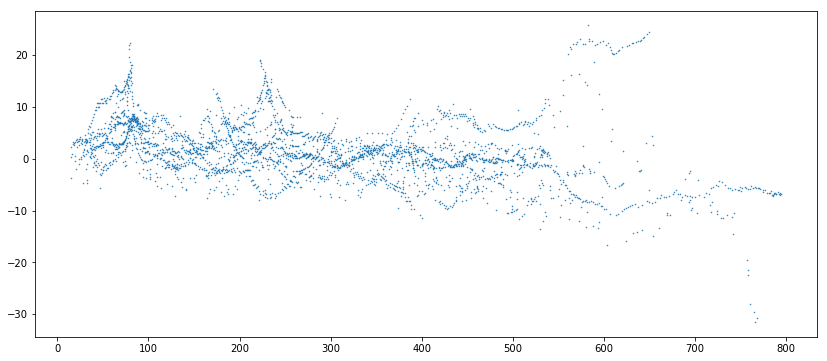

In [30]:
def calcT2(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    dots = np.add.reduce(b1 * b2, axis=1)
    l2 = np.add.reduce((a[:, 1] - a[:, 2])**2, axis=1)
    out = np.clip(dots / l2, 0, 1)
    return out

def sign(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    paddedB1 = np.pad(b1, ((0, 0), (0, 1)), 'constant', constant_values=(0,))
    paddedB2 = np.pad(b2, ((0, 0), (0, 1)), 'constant', constant_values=(0,))
    return np.sign(np.cross(paddedB1, paddedB2, axisa=1, axisb=1))[:, 2]

def getDiff2(t, a):
    projection = a[:,1,:] + np.repeat(t.reshape(-1, 1), 2, axis=1) * (a[:,2,:] - a[:,1,:])
    out = np.add.reduce((a[:,0,:]-projection) * (a[:,0,:]-projection), axis=1)
    return np.sqrt(out)

vCalcT2 = np.vectorize(calcT2, signature='(a,b,c)->(a)')
vGetDiff2 = np.vectorize(getDiff2, signature='(a),(a,b,c)->(a)')
vSign = np.vectorize(sign, signature='(a,b,c)->(a)')

def foo(a, b):
    d = 0
#     print(np.roll(b, 1, axis=0))
    m = np.zeros((a.shape[0], b.shape[0]-1, 3, 2))
    m[:, :, 0, :] = np.transpose(np.tile(a, [m.shape[1]+1, 1, 1]), axes=[1, 0, 2])[:, :-1, :]
    m[:, :, 1, :] = np.tile(b, [a.shape[0], 1, 1])[:, :-1, :]
    m[:, :, 2, :] = np.tile(np.roll(b, -1, axis=0), [a.shape[0], 1, 1])[:, :-1, :]
    t = vCalcT2(np.array(m))
    signs = vSign(np.array(m))
    distances = vGetDiff2(t, m)
    minDistIndex = np.argmin(distances, axis=1)
    asd = np.dstack((np.arange(minDistIndex.shape[0]), minDistIndex))[0]
    return minDistIndex + t[asd[:, 0], asd[:, 1]], distances[asd[:, 0], asd[:, 1]] * signs[asd[:, 0], asd[:, 1]]

deviationCloud = np.transpose(foo(cleanedCloud, spiralPolygon))
plt.figure(figsize=(14, 6))
plt.plot(deviationCloud[:, 0], deviationCloud[:, 1], '.', markersize=1)

(3368, 2) (3368,)


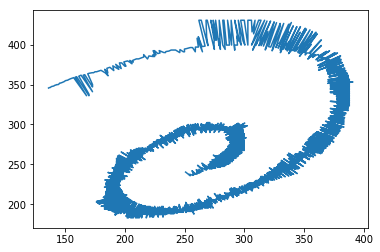

In [31]:
pointOrder = np.argsort(deviationCloud[:, 0])
sortedDeviationCloud = deviationCloud[np.argsort(deviationCloud[:, 0])]
print(cleanedCloud.shape, pointOrder.shape)
plt.plot(cleanedCloud[pointOrder, 0], cleanedCloud[pointOrder, 1])

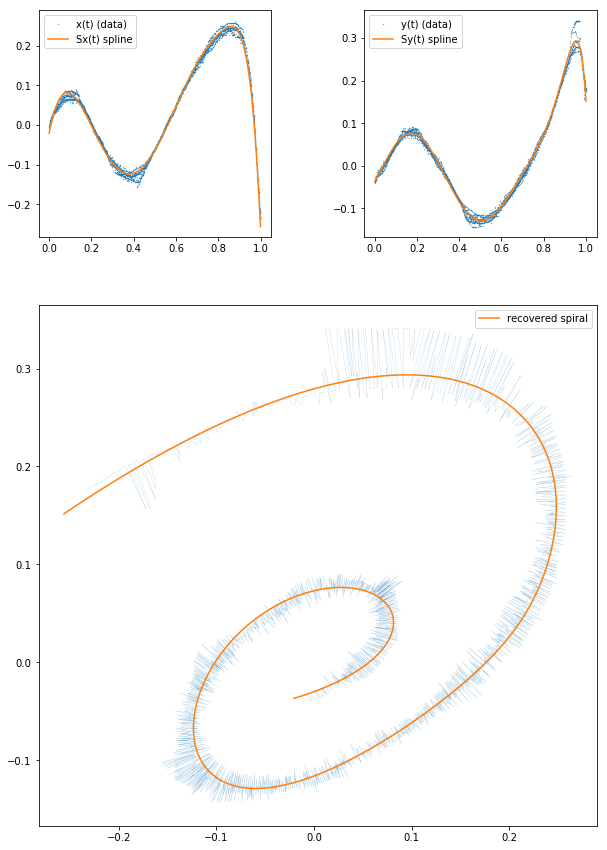

In [32]:
from scipy.interpolate import UnivariateSpline
plt.figure(figsize=(10, 15))

# for some reason the spline doesn't account for how far apart points are... yay! Normalise from -0.5 to 0.5
c2 = cleanedCloud / 512 - 0.5
t = np.linspace(0, 1, c2.shape[0])
Sx = UnivariateSpline(t, c2[pointOrder, 0], s=0.25, k=5)
Sy = UnivariateSpline(t, c2[pointOrder, 1], s=0.25, k=5)

grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1:, 0:])

ax1.plot(t, c2[pointOrder,0], '.', markersize=0.5, label='x(t) (data)')
ax1.plot(t, Sx(t), label='Sx(t) spline')
ax1.legend()

ax2.plot(t, c2[pointOrder,1], '.', markersize=0.5, label='y(t) (data)')
ax2.plot(t, Sy(t), label='Sy(t) spline')
ax2.legend()

t2 = np.linspace(0, 1, c2.shape[0])
ax3.plot(c2[pointOrder, 0], c2[pointOrder, 1], linewidth=0.1)
ax3.plot(Sx(t2), Sy(t2), label='recovered spiral')

ax3.legend()

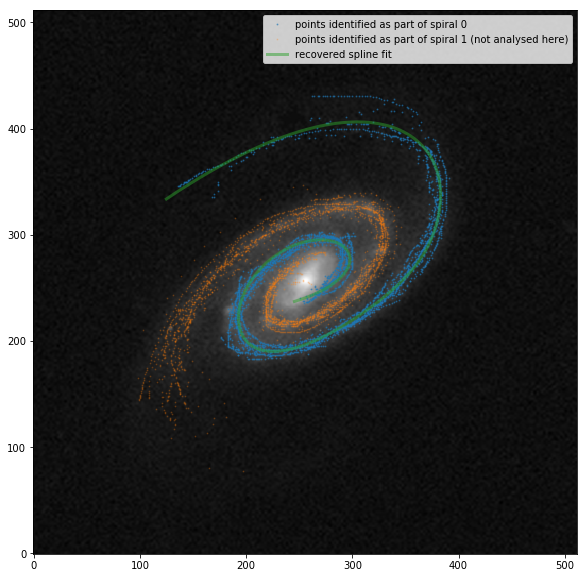

In [33]:
from PIL import Image
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))

pointCloud2 = np.array([
    point for arm in drawnArms[armLabels == 1] 
    for point in arm
])

pic = Image.open("./images/beta_subject.png")
ax.imshow(np.transpose(np.array(pic)[::-1, ::1]), cmap='gray', origin='lower')
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=2, alpha=0.5, label='points identified as part of spiral 0')
ax.plot(pointCloud2[:, 0], pointCloud2[:, 1], '.', markersize=2, alpha=0.2, label='points identified as part of spiral 1 (not analysed here)')
ax.plot((Sx(t2)+0.5)*512, (Sy(t2)+0.5)*512, linewidth=3, alpha=0.5, label='recovered spline fit')
plt.legend()